<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이론 보충

## 1.
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000494949026.
=> ReduceLROnPlateau : 파이토치의 학습률 스케줄러
목적 : 학습룰을 자동으로 줄임
효과 :  overshooting 방지
## 2.
 overshooting : 학습률이 너무 클 때 발생하는 현상
=> 최적점을 뛰어넘어 loss가 진동하거나 발산

Overshooting = 차가 너무 빨라서 목적지를 지나침
Overfitting = 한 길만 너무 잘 알아서 다른 길은 못 감

## 3.
왜 loss 와 Accuracy 그래프가 필요?

문제 발견
- 과적합(Overfitting) 감지
- 학습 부족(Underfitting) 확인  
- 학습률 문제 파악
- 언제 학습을 멈춰야 할지 판단

모델 성능 모니터링
- **실시간으로** 모델이 얼마나 잘 학습되고 있는지 확인
- **조기 종료** 시점 결정
- **하이퍼파라미터 튜닝**의 근거 제공


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Add ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy

In [3]:
# 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 파이썬 리스트 정의

In [4]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

*  X_signals (특성 수, 샘플 수, 타임스텝 수) => X_signals(샘플 수, 타임스텝 수, 특성 수)로 변환


In [5]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

#===데이터 전체 저장===
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # ===형태 변환===
    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


---

In [6]:
# load_y
#텍스트 파일 읽기, 라벨 파싱, 인덱스 조정

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return np.array(labels, dtype=np.int32) - 1

In [7]:
# Define paths for the training and testing label files
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

# Load the data
y_train = load_y(y_train_path)  # 훈련 데이터 레이블
y_test = load_y(y_test_path)    # 테스트 데이터 레이블

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("첫 번째 훈련 데이터 레이블:", y_train[0])
print("첫 번째 테스트 데이터 레이블:", y_test[0])

y_train shape: (7352,)
y_test shape: (2947,)
첫 번째 훈련 데이터 레이블: 4
첫 번째 테스트 데이터 레이블: 4


CNN(Convolutional Neural Network) 모델을 정의하고 컴파일

In [8]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (시간 스텝, 특성 수)
num_classes = 6  # 6가지 활동 분류

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,670 (631.52 KB)

 Trainable params: 160,774 (628.02 KB)

 Non-trainable params: 896 (3.50 KB)

None


In [11]:
# 모델 학습
history = model.fit(
    X_train,
    y_train,
    epochs=50,  # 충분히 많은 에폭 설정 (조기 종료가 멈춤)
    batch_size=64, # 배치 크기
    validation_split=0.2, # 검증 데이터 분할
    callbacks=[early_stop, reduce_lr], # 콜백 함수 적용
    class_weight=class_weights_dict # 클래스 가중치 적용
)

print("\n모델 학습 완료!")

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - loss: 0.5563 - sparse_categorical_accuracy: 0.7916 - val_loss: 2.4749 - val_sparse_categorical_accuracy: 0.2862 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9464 - val_loss: 2.0444 - val_sparse_categorical_accuracy: 0.3875 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.7095 - val_sparse_categorical_accuracy: 0.7288 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.2774 - val_sparse_categorical_accuracy: 0.9069 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - loss: 0.0801 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.2908 - val_sparse_categorical_accuracy: 0.9205 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 201

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step


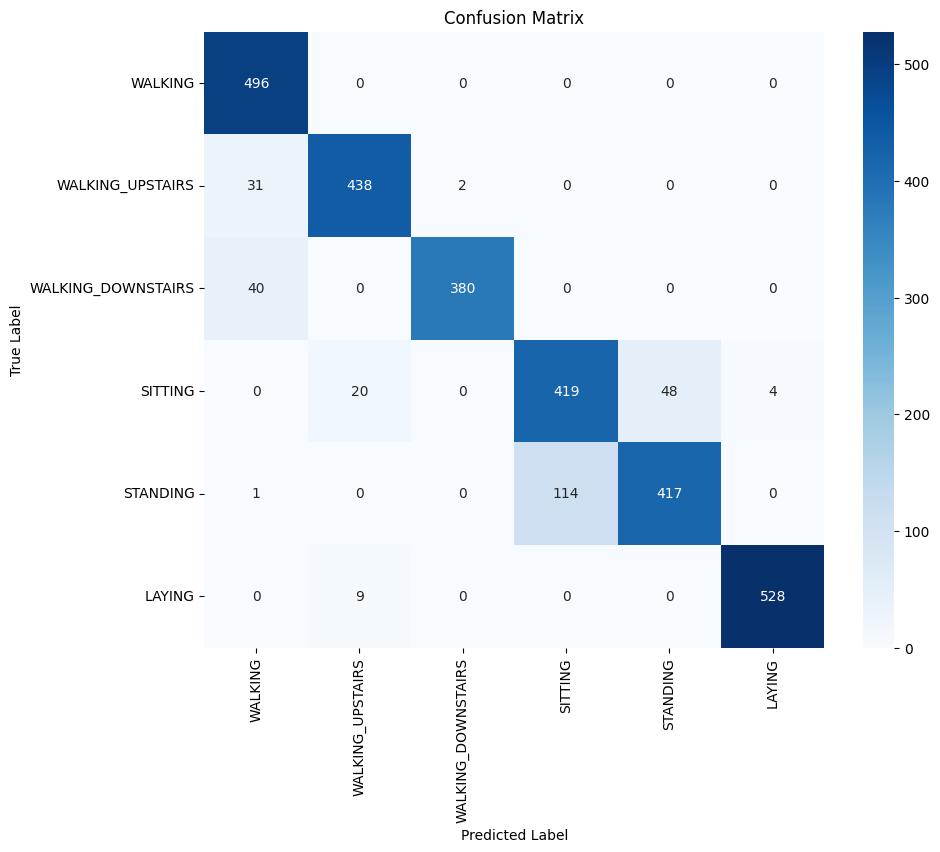

In [12]:
# 모델 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

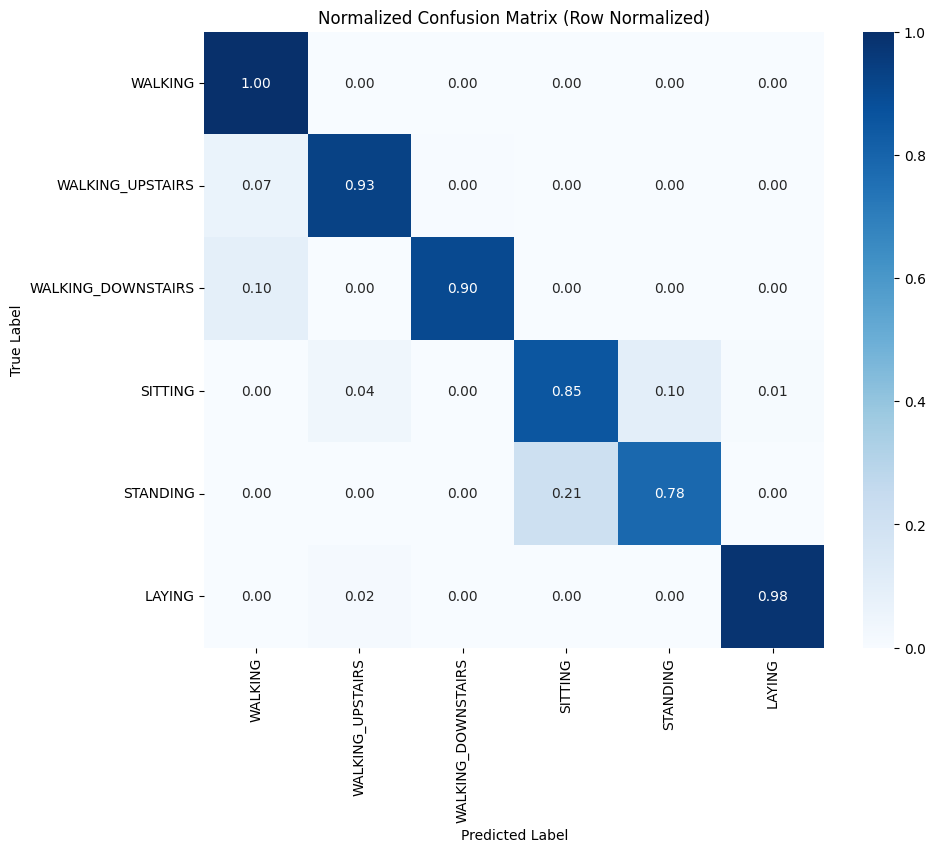

In [13]:
# 혼동 행렬 정규화 (각 행의 합으로 나누어 비율로 변환)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 정규화된 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Row Normalized)')
plt.show()

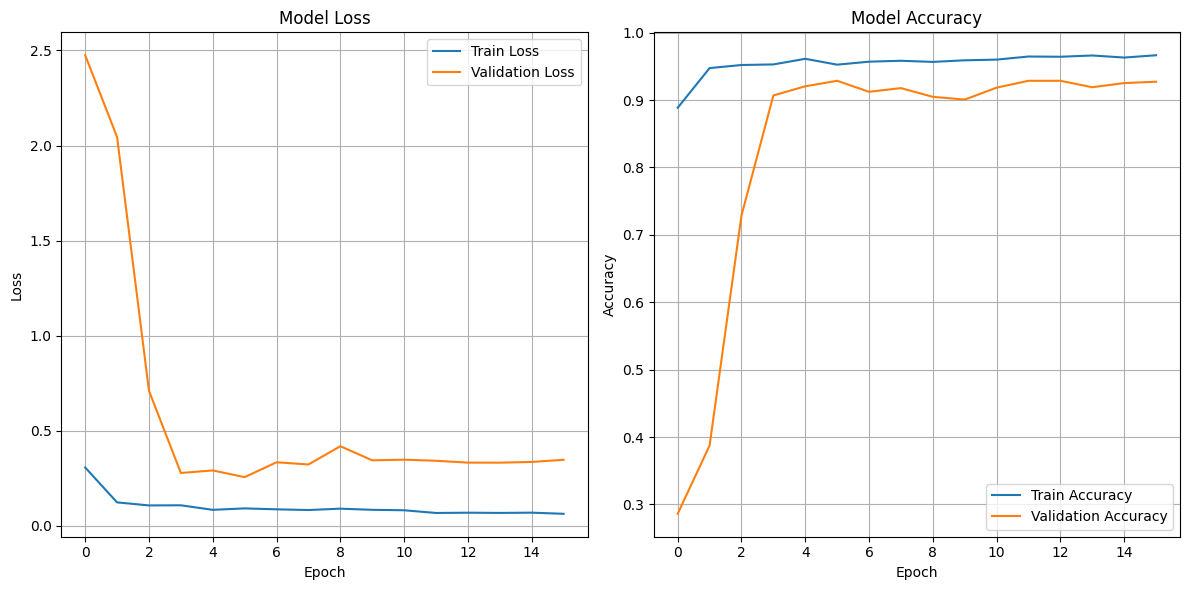

In [14]:
# 학습 과정 시각화 (Loss 및 Accuracy)
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.9087
테스트 데이터 손실 (Loss): 0.2510
